# Image Classification Experimantation Notebook

This is not a production notebook. However, it can be sufficiently used to:

1. Download image datasets from a certain URL
2. Visualize part of the set
3. Retrain a premade Neural Network from Keras Applications with pre-trained weights
4. Graph metrics during training
5. Calculate and plot the confusion matrix
6. Save the trained model
7. Save an optimized model

In [29]:
# import modules
import sys
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pylab as plt
import numpy as np
import os
import random
import matplotlib.image as mpimg

In [2]:
# directories
CWD = os.getcwd() # current working directory
IMAGE_DATA = os.path.join(CWD,'data') # data directory

In [33]:
# define image classes' names
classes = [x for x in os.listdir(IMAGE_DATA) if os.path.isdir(os.path.join(IMAGE_DATA,x))]
num_classes = len(classes)

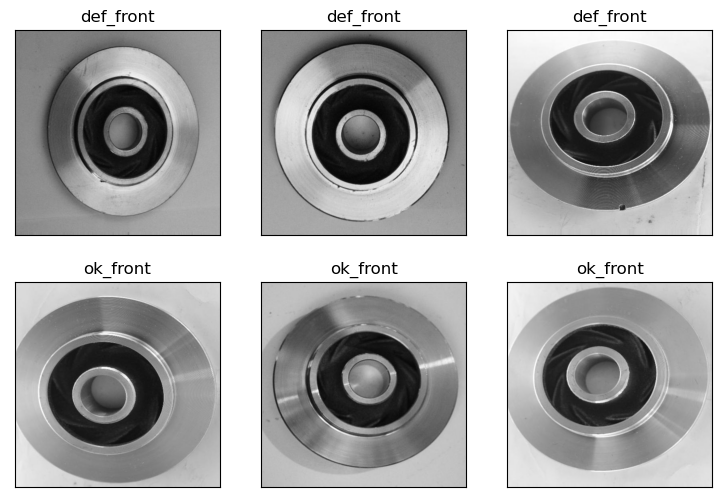

In [30]:
# display sample image data set
num_images = 3  # number of images per class
image_size = 3  # size of the displayed images in inches
fig, ax = plt.subplots(nrows=len(classes), ncols=num_images, figsize=(image_size * num_images, image_size * len(classes)))

for i, c in enumerate(classes):
    class_dir = os.path.join(IMAGE_DATA, c)
    class_files = os.listdir(class_dir)
    random_files = random.sample(class_files, num_images)
    
    for j, f in enumerate(random_files):
        img = mpimg.imread(os.path.join(class_dir, f))
        ax[i][j].imshow(img)
        ax[i][j].set_title(c)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

plt.show()

## Image Data Generators for Training and Validation

Below, we define the image data generators for training and validation datasets.

The code uses the `ImageDataGenerator` class from the `tf.keras.preprocessing.image` module to create generators that read and preprocess images from a directory on the disk.

### Parameters

- `IMAGE_SIZE`: an integer that specifies the size of the images to be used as input to the model. The images are resized to this size during preprocessing.
- `BATCH_SIZE`: an integer that specifies the number of images to be loaded and processed together in each batch during training and validation.
- `SCALE`: an integer or float that specifies the factor by which the image pixel values are to be rescaled. In this case, the pixel values are divided by 255 to bring them into the range of 0 to 1.
- `validation_split`: a float that specifies the fraction of images to be used for validation. In this case, 20% of the images are used for validation.
- `subset`: a string that specifies whether the generator should be used for the 'training' or 'validation' dataset.

The generators, `train_generator` & `val_generator` can then be used as input to a machine learning model that requires image data as input.

In [31]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
SCALE = 255

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./SCALE, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    IMAGE_DATA,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    IMAGE_DATA,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 1042 images belonging to 2 classes.
Found 259 images belonging to 2 classes.


## Extract a batch of images and labels from the val_generator generator

- `image_batch`: a tensor of shape `(batch_size, height, width, channels)` that contains a batch of images loaded from the generator.
- `label_batch`: a tensor of shape `(batch_size, num_classes)` that contains the corresponding labels for each image in the image_batch.

The `next()` method is used to extract a single batch of images and labels from the `val_generator` generator. The size of the batch is specified by the `batch_size` parameter used when creating the generator.

The resulting `image_batch` and `label_batch` tensors are then printed to the console using the `print()` function. The image_batch tensor has a shape of `(batch_size, height, width, channels)` where `height` and `width` correspond to the dimensions of each image in the batch, and `channels` corresponds to the number of color channels in the images (e.g., 3 for RGB images). The `label_batch` tensor has a shape of `(batch_size, num_classes)` where `num_classes` is the number of classes in the dataset, and each row corresponds to the one-hot encoded label for each image in the batch.

In [32]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 2))

## Extract a Batch of Images and Labels from a Training Generator

Here we extract a batch of images and labels from the `train_generator` generator.

### Parameters
- `x_train`: a tensor of shape `(batch_size, height, width, channels)` that contains a batch of images loaded from the generator.
- `y_train`: a tensor of shape `(batch_size, num_classes)` that contains the corresponding labels for each image in the x_train tensor.

The `next()` method is used to extract a single batch of images and labels from the `train_generator` generator. The size of the batch is specified by the `batch_size` parameter used when creating the generator.

The resulting `x_train` and `y_train` tensors contain the batch of images and labels, respectively, and can be used to train a machine learning model.

In [34]:
x_train, y_train = next(train_generator)

In [38]:
# print the class indices and store them in the filesystem
print(train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open(os.path.join(CWD,'image_labels.txt'), 'w') as f:
  f.write(labels)

{'def_front': 0, 'ok_front': 1}


## Create a Base Model using the Pre-Trained MobileNet V2

### Parameters

- `IMG_SHAPE`: a tuple that specifies the expected shape of the input image, which is `(IMAGE_SIZE, IMAGE_SIZE, 3)`. The first two values correspond to the height and width of the image, while the third value corresponds to the number of channels (e.g., 3 for RGB images).
- `input_shape`: a tuple that specifies the expected shape of the input tensor for the base model. In this case, it is set to `IMG_SHAPE`.
- `include_top`: a boolean value that specifies whether to include the fully connected layer at the top of the network. In this case, it is set to False because the top layer will be replaced by a new one that is specific to the current problem.
- `weights`: a string that specifies the pre-trained weights to use for the base model. In this case, it is set to 'imagenet' to use the weights trained on the ImageNet dataset.
- `base_model`: the pre-trained MobileNet V2 model that will serve as the base model for transfer learning.
- `base_model.trainable`: a boolean value that specifies whether the weights of the base model should be trainable during the fine-tuning process. In this case, it is set to False to freeze the weights of the pre-trained model.

The trainable attribute of the `base_model` object is set to `False` to freeze the weights of the pre-trained model. This is done to prevent the weights from being updated during the training process, and to ensure that the pre-trained features are preserved.

In [39]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable = False

2023-02-25 00:22:00.499668: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-25 00:22:00.501792: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Create custom model using Transfer Learning

The following code creates a custom model for classification using transfer learning with the MobileNet V2 base model.

### Parameters

- `base_model`: the pre-trained MobileNet V2 model that serves as the base model for transfer learning.
- `tf.keras.Sequential()`: a function that creates a sequential model, which is a linear stack of layers.
- `tf.keras.layers.Conv2D()`: a convolutional layer that performs convolution operations on the input data. The filters parameter specifies the number of output filters in the layer, the kernel_size parameter specifies the size of the convolution kernel, and the activation parameter specifies the activation function to use.
- `tf.keras.layers.Dropout()`: a regularization layer that randomly drops some of the input units to prevent overfitting. The 0.2 parameter specifies the fraction of the input units to drop.
- `tf.keras.layers.GlobalAveragePooling2D()`: a pooling layer that performs global average pooling on the input data. This reduces the spatial dimensions of the input and produces a feature vector that can be used as input to the final dense layer.
- `tf.keras.layers.Dense()`: a fully connected layer that produces the final output of the model. The units parameter specifies the number of output units, which is set to `num_classes`. The activation parameter specifies the activation function to use, which is 'softmax' for multi-class classification.

The `Conv2D` layer applies a convolution operation to the input data with 32 output filters, a kernel size of 3, and the ReLU activation function. The `Dropout` layer randomly drops 20% of the input units to prevent overfitting. The `GlobalAveragePooling2D` layer performs global average pooling on the output of the previous layer to produce a feature vector that is fed into the final Dense layer.

The `Dense` layer produces the final output of the model, which is a probability distribution over the two classes. The units parameter is set to `num_classes` to output a probability for each of the classes, and the activation parameter is set to 'softmax' to ensure that the output values are normalized and sum to 1.

In [40]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=num_classes, activation='softmax')
])

## Compile the model

In [41]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 2,626,722
Trainable params: 368,738
Non-tr

In [43]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 4


In [44]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=5,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/5
17/17 [==============================] - 25s 1s/step - loss: 1.5794 - accuracy: 0.5902 - val_loss: 0.4755 - val_accuracy: 0.7490
Epoch 2/5
17/17 [==============================] - 20s 1s/step - loss: 0.4488 - accuracy: 0.7236 - val_loss: 0.4291 - val_accuracy: 0.8494
Epoch 3/5
17/17 [==============================] - 20s 1s/step - loss: 0.4101 - accuracy: 0.8109 - val_loss: 0.4159 - val_accuracy: 0.8649
Epoch 4/5
17/17 [==============================] - 23s 1s/step - loss: 0.3915 - accuracy: 0.8474 - val_loss: 0.4005 - val_accuracy: 0.8958
Epoch 5/5
17/17 [==============================] - 20s 1s/step - loss: 0.3566 - accuracy: 0.8685 - val_loss: 0.3528 - val_accuracy: 0.8147


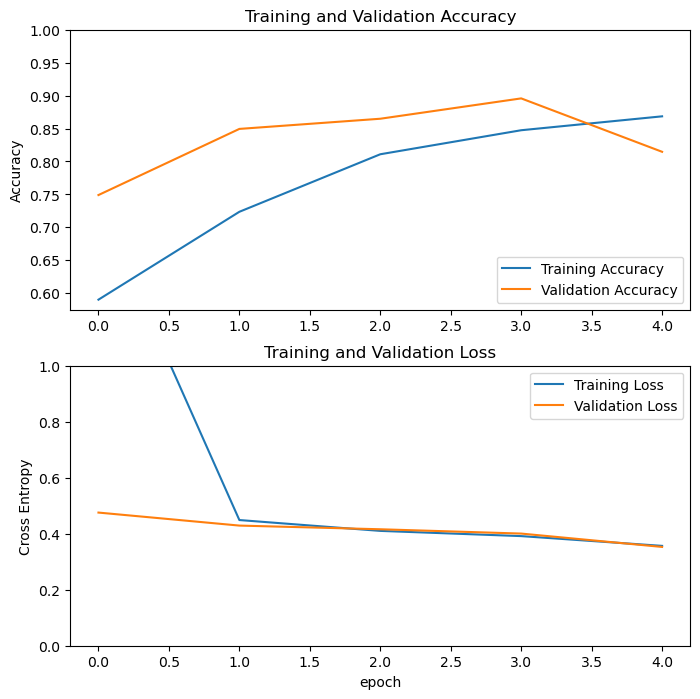

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
# Use the model to make predictions on the validation set
Y_pred = model.predict_generator(val_generator, val_generator.n // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
# Get the true labels of the validation set
y_true = val_generator.classes

# Calculate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')
classes = val_generator.class_indices.keys()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Save the trained model
model.save('flower_classification_model.h5')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224.tflite', 'wb') as f:
  f.write(tflite_model)